# Vehicle detection using cv
## Load data

In [1]:
# load files from both class -> search for function
# preprocess -> normalize, shuffle
# implement sliding windows
# implement hog, color
# combine and normalize features
# implement heatmap
# implement tracking

In [144]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time
from sklearn.externals import joblib

In [3]:
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')

print('data size cars: {} non-cars: {}'.format(len(cars), len(notcars)))

data size cars: 8792 non-cars: 8968


In [4]:
# visualize few samples
def show_samples_path(path_list, number=10):
    f, axs = plt.subplots(number // 5, 5, figsize=(20,number))    
    show_list = random.sample(path_list, number)
    for i in range(number):
        img = mpimg.imread(show_list[i])
        axs[i//5, i % 5].imshow(img)
    plt.show()

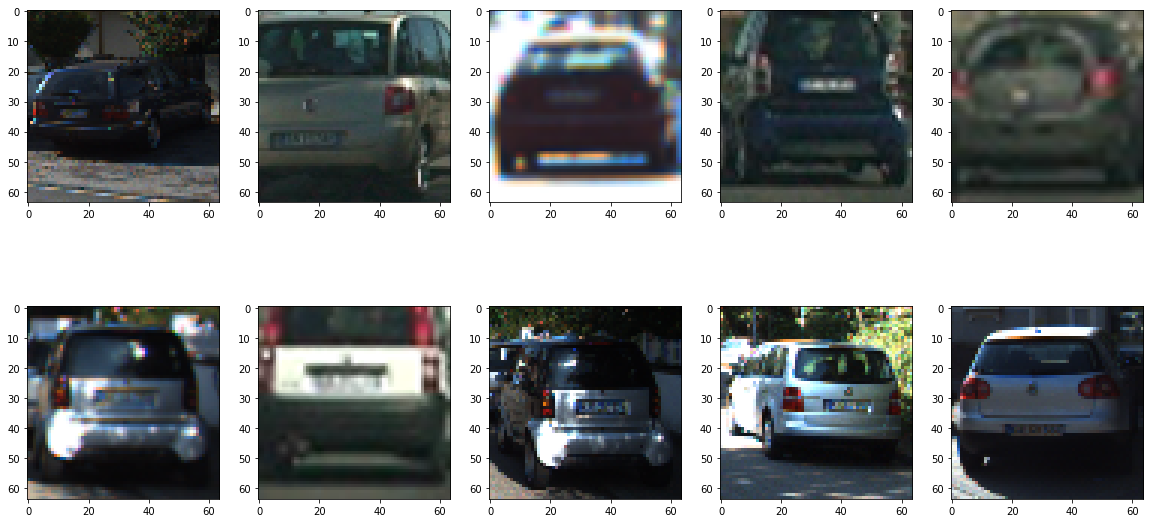

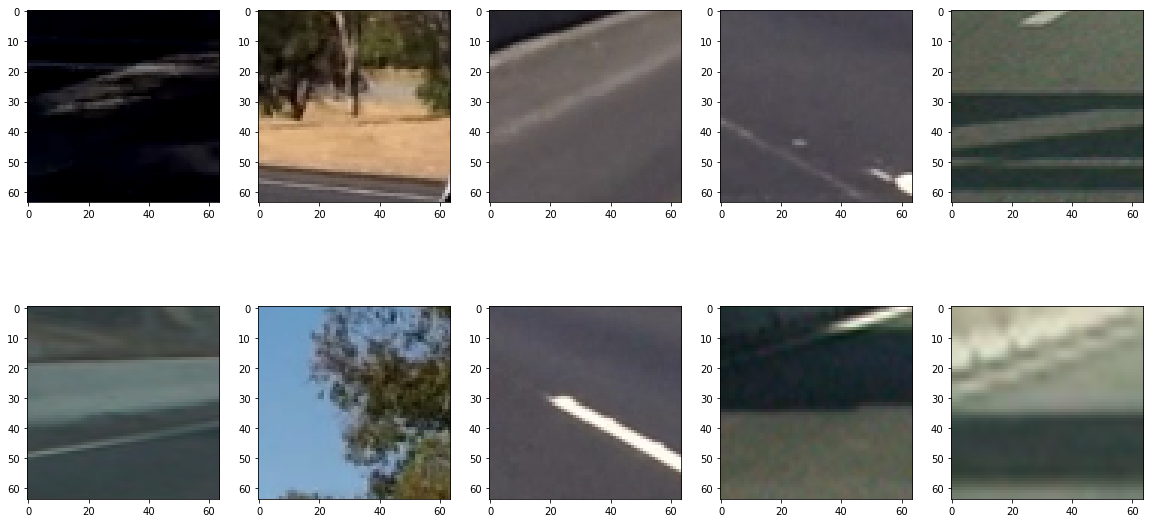

In [5]:
show_samples_path(cars, 10)
show_samples_path(notcars, 10)

In [147]:
def bin_spatial(img, size=(32,32)):
    features = cv2.resize(img, size).ravel()
    return features


def color_hist(img, nbins=32, channel=None, bins_range=(0,256)):    
    if channel is None:
        chan1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        chan2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        chan3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)        
        hist_features = np.concatenate((chan1[0], chan2[0], chan3[0]))    
    elif type(channel) == int and 0 < channel < img.shape[2]:
        hist_features = np.histogram(img[:,:,channel], bins=nbins)[0]
    else:
        raise Exception('channel should be int value between 0 and 2')
    return hist_features


def get_hog(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def extract_feature(img, cspace='RGB', orient=9, hog_channel=None, 
                    pix_per_cell=8, cell_per_block=2, channel=None, spatial_size=(32,32), hist_bins=32, hist_range=(0,256)):    
    """
    Extract features from single image
    """    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)    
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, channel=channel, nbins=hist_bins, bins_range=hist_range)
    if hog_channel is None:
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog(feature_image[..., channel], orient, pix_per_cell,
                                       cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog(feature_image[...,hog_channel], orient, pix_per_cell,
                              cell_per_block, vis=False, feature_vec=True)
    return np.concatenate([spatial_features, hist_features, hog_features])

def dir_extract_feature(img_dir, cspace='RGB', orient=9, hog_channel=None, 
                    pix_per_cell=8, cell_per_block=2, channel=None, spatial_size=(32,32), hist_bins=32, hist_range=(0,256)):  
    """
    Extract features from image directory
    """
    features = []
    for img_path in img_dir:        
        img = mpimg.imread(img_path)
        if img_path.split('.')[-1] != 'png':
            img = img.astype(np.float32) / 255        
        features.append(extract_feature(img, cspace='RGB', orient=9, hog_channel=None, 
                    pix_per_cell=8, cell_per_block=2, channel=None, spatial_size=(32,32), hist_bins=32, hist_range=(0,256)))
    return features

## visualize hog features

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


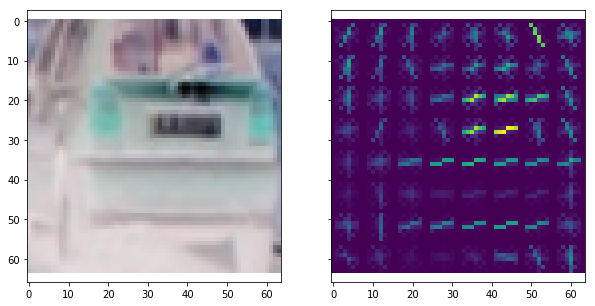

[ 0.01624668  0.09204409  0.07085295 ...,  0.02188569  0.03074406
  0.04760068]


In [110]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
img = mpimg.imread(cars[100]) * 255
ax1.imshow(img)
ax2.imshow(get_hog(img[...,1], vis=True, feature_vec=True)[1])
plt.show()
print (get_hog(img[...,0], vis=False, feature_vec=True))

## train data

In [116]:
car_features = dir_extract_feature(cars, cspace='RGB', hog_channel=0, spatial_size=(32,32), hist_bins=32, hist_range=(0,256))
notcar_features = dir_extract_feature(notcars, cspace='RGB', hog_channel=2, spatial_size=(32,32), hist_bins=32, hist_range=(0,256))                                

/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


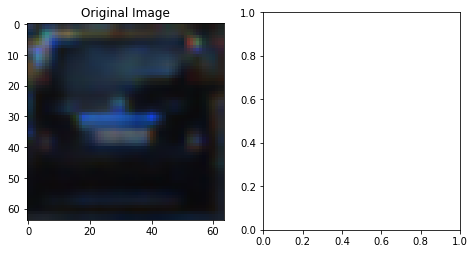

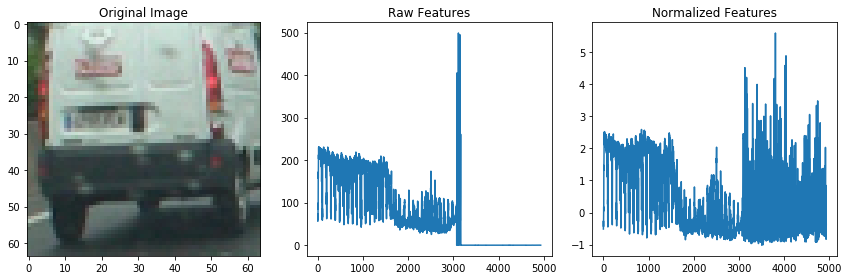

In [117]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

In [118]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=.2, random_state=1)

In [119]:
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'sec to train SVC')
print('Test accuracy of SVC: {}'.format(round(svc.score(X_test, y_test), 4)))
t = time.time()
n_predict = 10
print('Predicts: ', svc.predict(X_test[0:n_predict]))
print('Truth: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'sec to predict {} samples'.format(n_predict))

13.53 sec to train SVC
Test accuracy of SVC: 0.9823
Predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
Truth:  [ 1.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.00246 sec to predict 10 samples


In [146]:
# save classifier and scaler to disk
joblib.dump(svc, './svc')
joblib.dump(X_scaler, './scaler')

['./scaler']

## sliding window

In [130]:
test_image = glob.glob('./test_images/*.jpg')

In [139]:
def draw_boxes(img, boxes, color=(0,0,255), thick=6):
    imcopy = np.copy(img)
    for box in boxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thick)
    return imcopy

def sliding_window(img, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(64, 64), xy_overlap=(.5,.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    x_step = int(xy_window[0] * xy_overlap[0])
    y_step = int(xy_window[1] * xy_overlap[1])
    
    window_list = []
    for xi in range(x_start_stop[0], x_start_stop[1], x_step):
        for yi in range(y_start_stop[0], y_start_stop[1], y_step):
            window_list.append(((xi, yi), (xi+x_step, yi+y_step)))
    return window_list 

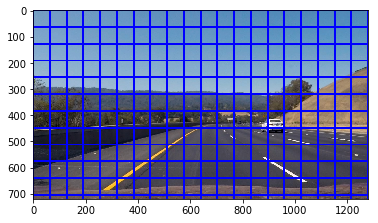

In [140]:
image = mpimg.imread(test_image[0])

windows = sliding_window(image, xy_window=(128,128), xy_overlap=(.5,.5))
window_img = draw_boxes(image, windows)
plt.imshow(window_img)
plt.show()

In [154]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_feature(test_img,  
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
# set params


/home/rtvdnn/anaconda3/envs/keras/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


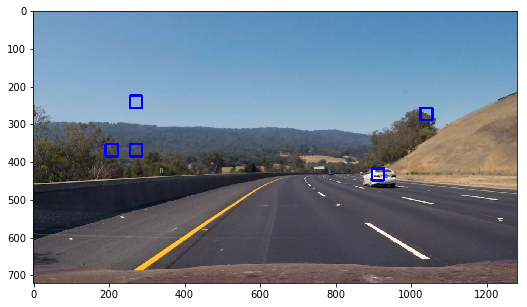

In [156]:
image = mpimg.imread(test_image[0])
out_image = np.copy(image)
windows = sliding_window(image)
hot_windows = search_windows(image, windows, svc, X_scaler)
window_img = draw_boxes(out_image, hot_windows)
fig = plt.figure(figsize=(10,5))
plt.imshow(window_img)
plt.show()